In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.backends.backend_pdf
pd.options.mode.chained_assignment = None  # default='warn'

# MOp merfish gene/ontology results on 19 ontologies mapped to 10Xv3

In [53]:
mop_df = pd.read_csv('../outputs/gene_ontology/MOp_periphal_ReadZs_10X_gene_ontology.csv')
mop_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,0.000082,0.000293
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.032479,2.767631,6.067670,1.123562,0.261199,0.367769
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.094270,25.067569,29.188310,4.639891,0.000003,0.000015
3,m1s1,Acta2,L6 CT,26,5.0,304.0,0.176217,4.241585,3.271222,2.345164,0.019019,0.040833
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.035714,2.599184,10.194193,0.814068,0.415606,0.527449


In [54]:
mop_df['ontology'].nunique()

19

In [55]:
sample_pair_df = mop_df.pivot(
    index = ['gene','ontology'],
    columns = 'sample_id',
    values = 'med_score',
)

sample_pair_df

sample_id               m1s1      m1s2      m1s3      m1s4      m1s5  m1s6  \
gene    ontology                                                             
Acta2   L2/3 IT     0.087413  0.102431  0.146667  0.117647  0.104851   NaN   
        L5 ET       0.032479       NaN       NaN -0.009728  0.380703   NaN   
        L5 IT       0.094270  0.116424  0.114403  0.161401  0.194820   NaN   
        L6 CT       0.176217       NaN       NaN  0.218605  0.157537   NaN   
        L6 IT       0.035714  0.214753  0.189794  0.212669  0.172080   NaN   
...                      ...       ...       ...       ...       ...   ...   
Wnt7b   OPC         0.124394  0.092391  0.064327  0.108571  0.036496   NaN   
Zfp804b L5 ET            NaN       NaN       NaN       NaN -0.229299   NaN   
        L6 CT            NaN       NaN       NaN       NaN -0.151163   NaN   
        L6 IT            NaN       NaN       NaN -0.457143 -0.295920   NaN   
        L6 IT Car3       NaN -0.262329 -0.076041 -0.253463       NaN   NaN   

sample_id               m2s1      m2s2      m2s3     m2s4     m2s5      m2s6  
gene    ontology                                                              
Acta2   L2/3 IT     0.030987       NaN       NaN      NaN      NaN       NaN  
        L5 ET            NaN       NaN       NaN      NaN      NaN       NaN  
        L5 IT            NaN       NaN       NaN      NaN      NaN       NaN  
        L6 CT            NaN       NaN       NaN      NaN      NaN       NaN  
        L6 IT            NaN       NaN       NaN      NaN      NaN       NaN  
...                      ...       ...       ...      ...      ...       ...  
Wnt7b   OPC         0.046632  0.063218  0.064935  0.09061  0.12493  0.156864  
Zfp804b L5 ET            NaN       NaN       NaN      NaN      NaN       NaN  
        L6 CT            NaN       NaN       NaN      NaN      NaN       NaN  
        L6 IT            NaN       NaN       NaN      NaN      NaN       NaN  
        L6 IT Car3       NaN       NaN       NaN      NaN      NaN       NaN  

[1370 rows x 12 columns]

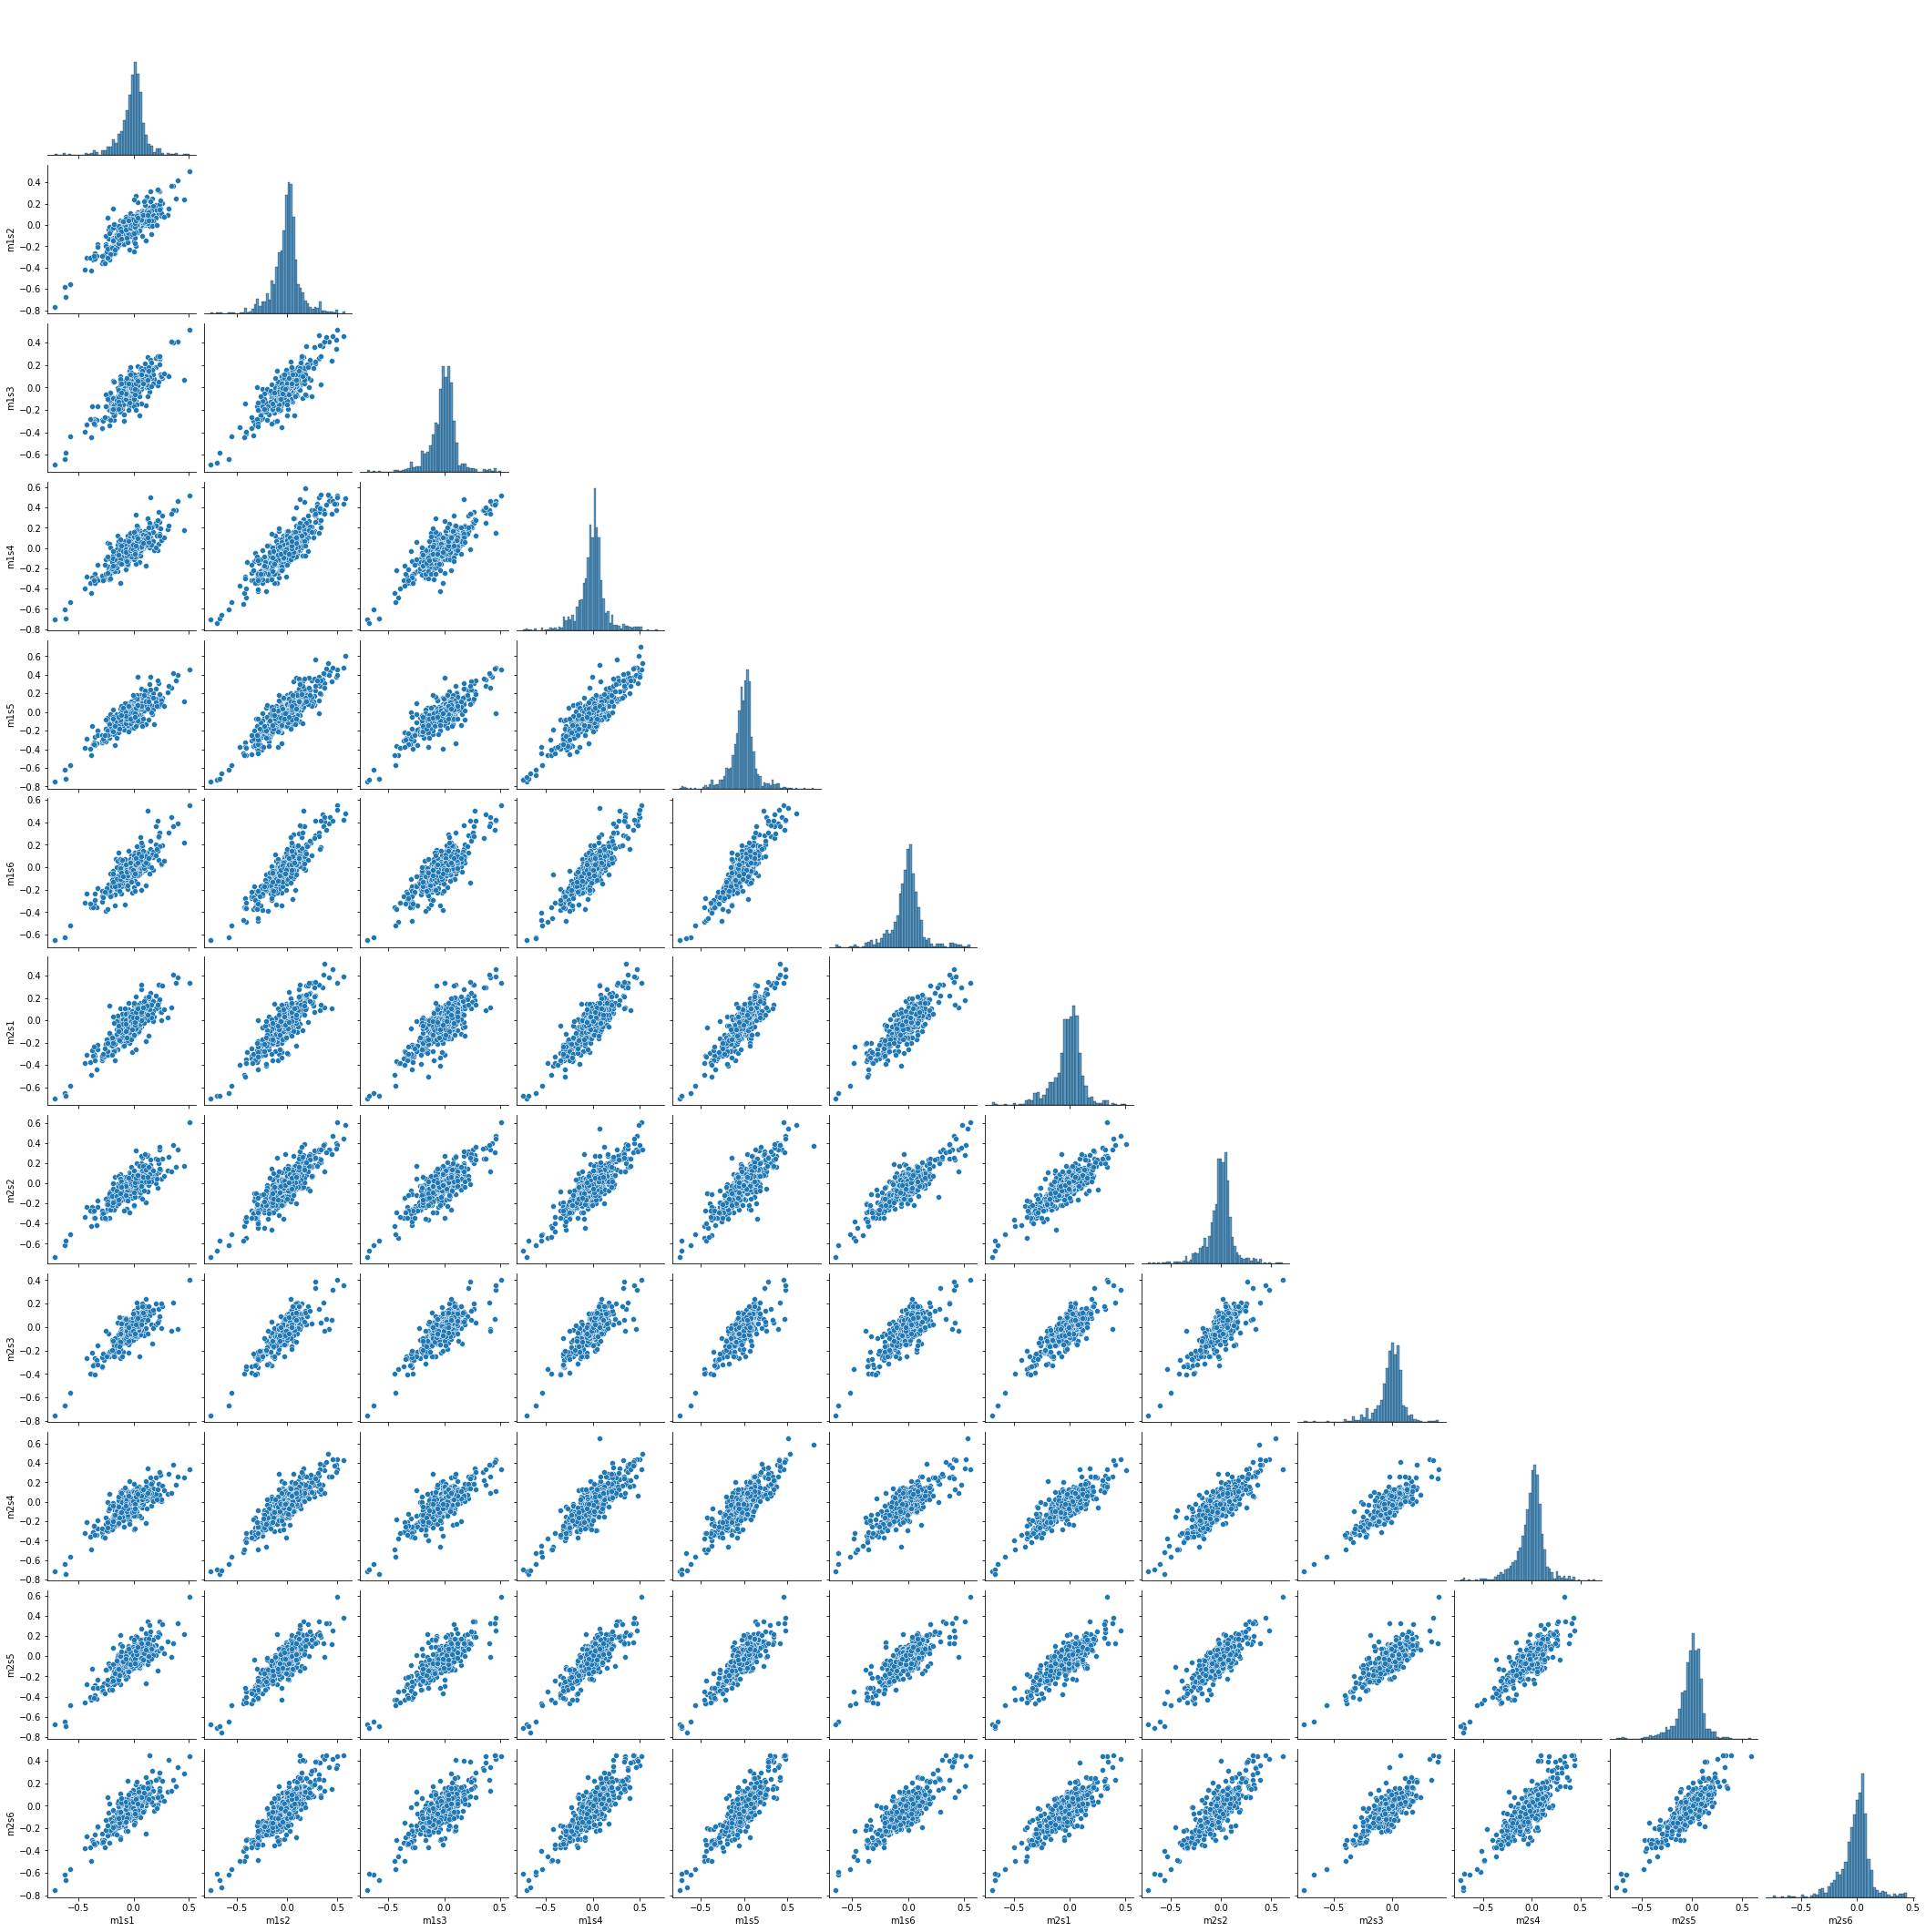

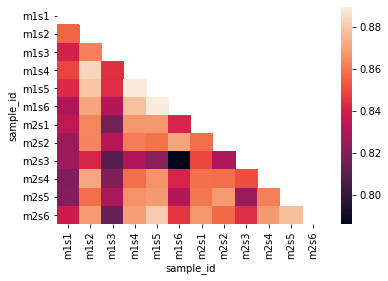

In [56]:
#Goal of these plots is to show that gene/ontology median score is well-correlated across biological replicates

#pairplot
sns.pairplot(
    sample_pair_df,
    corner=True,
)
plt.show()
plt.close()


#heatmap
hm_df = sample_pair_df.corr()
mask = np.zeros_like(hm_df)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    hm_df,
    mask=mask,
)
plt.show()
plt.close()

In [57]:
#68 genes have significant peripheral in at least one celltype,
#and significant central in at least one other celltype
pos_and_neg_sig = (
    mop_df[
        mop_df['bh_p'].le(0.05)
    ].groupby('gene').filter(
        lambda g: g['med_score'].gt(0).nunique() > 1
    )
)

pos_and_neg_sig['gene'].nunique()

68

In [58]:
pos_and_neg_sig['gene'].value_counts()

Ptprt      92
Dscaml1    90
Luzp2      89
Nr4a1      81
Rgs6       77
           ..
Cacng5      6
Lhx6        3
Prox1       3
Syt10       2
Lsp1        2
Name: gene, Length: 68, dtype: int64

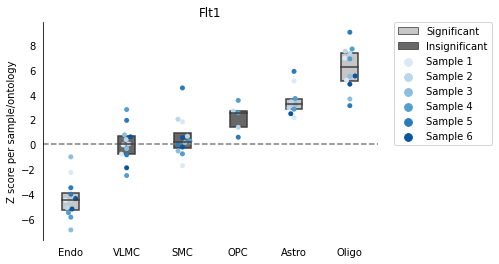

In [118]:
# simplified diagram for a single gene
gene = 'Flt1'

plot_df = mop_df[mop_df['gene'].eq(gene)].copy()
plot_df = plot_df.groupby('ontology').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
plot_df['mouse'] = 'Mouse '+plot_df['sample_id'].str[1]
plot_df['sample'] = 'Sample '+plot_df['sample_id'].str[3]
plot_df['mean_ont_z'] = plot_df.groupby('ontology')['z'].transform('mean')
sig = plot_df.groupby('ontology')['bh_p'].transform('mean').le(0.05)
plot_df['significant'] = np.where(sig,'Significant','Insignificant')
plot_df = plot_df.sort_values('mean_ont_z')

ax = sns.swarmplot(
    x = 'ontology',
    y = 'z',
    hue = 'sample',
    hue_order = sorted(plot_df['sample'].unique()),
    palette = 'Blues',
    data = plot_df,
)
sns.boxplot(
    x = 'ontology',
    y = 'z',
    hue = 'significant',
    dodge = False,
    width=0.3,
    #showbox=False,
    whiskerprops={'visible':False},
    showcaps=False,
    #capprops={'color':'white'},
    palette = 'Greys',
    fliersize = 0,
    data = plot_df,
    zorder = 10,
    ax = ax,
)
ax.tick_params(left=False, bottom=False)
sns.despine(bottom=True)
plt.axhline(0,linestyle='dashed',color='grey')
plt.title('{}'.format(gene))
plt.xlabel('')
plt.ylabel('Z score per sample/ontology')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

In [134]:
# simplified diagram making a separate plot for each gene
pdf = matplotlib.backends.backend_pdf.PdfPages('srrs_MERFISH_simplified_peripheral.pdf')

for gene,plot_df in mop_df.groupby('gene'):

    plot_df = plot_df.groupby('ontology').filter(lambda g: len(g) >= 3) #filtering out ontologies with too few samples
    plot_df['mouse'] = 'Mouse '+plot_df['sample_id'].str[1]
    plot_df['sample'] = 'Sample '+plot_df['sample_id'].str[3]
    plot_df['mean_ont_z'] = plot_df.groupby('ontology')['z'].transform('mean')
    sig = plot_df.groupby('ontology')['bh_p'].transform('mean').le(0.05)
    plot_df['significant'] = np.where(sig,'Significant','Insignificant')
    plot_df = plot_df.sort_values(['mean_ont_z','significant'])

    if plot_df.empty:
        continue
    
    ax = sns.stripplot(
        x = 'ontology',
        y = 'z',
        hue = 'sample',
        hue_order = sorted(plot_df['sample'].unique()),
        palette = 'Blues',
        data = plot_df,
    )
    sns.boxplot(
        x = 'ontology',
        y = 'z',
        hue = 'significant',
        dodge = False,
        width=0.3,
        whiskerprops={'visible':False},
        showcaps=False,
        palette = {'Insignificant':'grey','Significant':'brown'},
        fliersize = 0,
        data = plot_df,
        zorder = 10,
        ax = ax,
    )
    ax.tick_params(left=False, bottom=False)
    sns.despine(bottom=True)
    plt.axhline(0,linestyle='dashed',color='grey')
    plt.title('{}'.format(gene))
    plt.xlabel('')
    plt.ylim(-10,10)
    plt.ylabel('Z score per sample/ontology')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    #plt.show()
    pdf.savefig()
    plt.close()
    
pdf.close()

True

In [59]:
#gene-cell level df
gc_mop = pd.read_csv('../outputs/gene_cell/MOp_periphal_ReadZs_gene_ontology.csv')
gc_mop.head()

,metric,cell_id,num_spots,gene,num_gene_spots,median_rank,score,variance,mouse,sample,replicate,sample_id,ontology
0,peripheral,10000143038275111136124942858811168393,168,Cxcl14,13,67.0,0.209581,0.062617,2,4,1,m2s4,Astro
1,peripheral,10000143038275111136124942858811168393,168,Daam2,23,113.0,-0.341317,0.035146,2,4,1,m2s4,Astro
2,peripheral,10000143038275111136124942858811168393,168,Egfr,6,56.0,0.341317,0.105180,2,4,1,m2s4,Astro
3,peripheral,10000143038275111136124942858811168393,168,Igfbp5,12,44.5,0.479042,0.062329,2,4,1,m2s4,Astro
4,peripheral,10000143038275111136124942858811168393,168,Pdlim5,5,108.0,-0.281437,0.141105,2,4,1,m2s4,Astro


In [34]:
mop_df[mop_df['gene'].eq('Flt1')]

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
215,m1s1,Flt1,Astro,27,9.0,162.0,0.072581,3.268618,2.293748,2.158198,3.091247e-02,0.062354
216,m1s1,Flt1,Endo,277,29.0,152.0,-0.048193,-13.085714,8.465300,-4.497553,6.874014e-06,0.000029
217,m1s1,Flt1,Oligo,26,8.0,230.0,0.362915,7.744770,2.250492,5.162616,2.435227e-07,0.000001
218,m1s1,Flt1,SMC,158,13.0,281.0,-0.088702,-5.589085,10.713436,-1.707561,8.771778e-02,0.151423
219,m1s1,Flt1,VLMC,87,7.0,311.0,-0.027668,-0.113430,8.212736,-0.039581,9.684273e-01,0.977833
...,...,...,...,...,...,...,...,...,...,...,...,...
10842,m2s6,Flt1,Astro,25,10.0,183.0,0.089494,3.492335,1.996224,2.471788,1.344391e-02,0.030072
10843,m2s6,Flt1,Endo,325,29.0,161.0,-0.050000,-13.455823,9.562945,-4.351254,1.353611e-05,0.000054
10844,m2s6,Flt1,Oligo,45,11.0,268.0,0.227848,9.162989,3.568853,4.850347,1.232455e-06,0.000006
10845,m2s6,Flt1,SMC,177,15.0,373.0,-0.022624,1.816834,11.183528,0.543283,5.869352e-01,0.685203


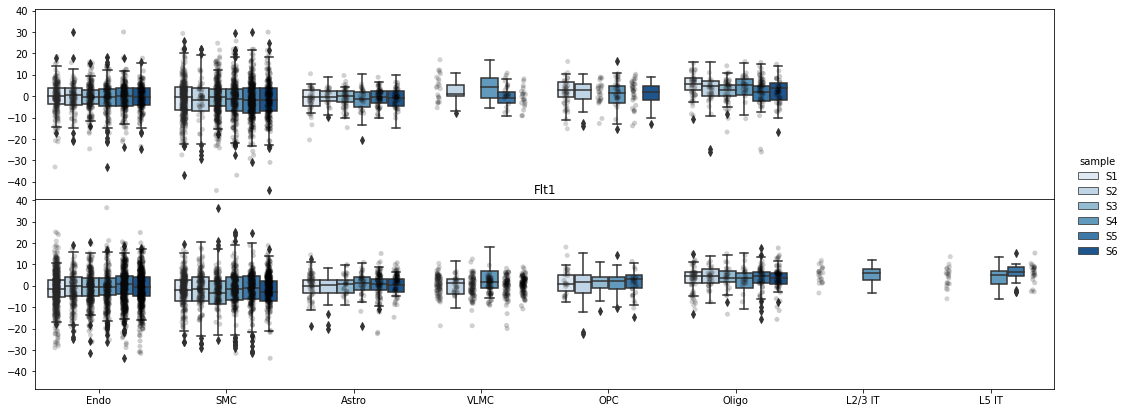

In [29]:
#Boxplots for a single gene of interest
gene = 'Flt1'

plot_df = gc_mop[gc_mop['gene'].eq(gene)].copy()
plot_df['Normalized score'] = plot_df['score'].div(plot_df['variance'])
plot_df['mouse'] = 'Mouse '+plot_df['sample_id'].str[1]
plot_df['sample'] = 'S'+plot_df['sample_id'].str[3]

g = sns.catplot(
    x = 'ontology',
    y = 'Normalized score',
    kind = 'box',
    height = 3,
    aspect = 5,
    hue = 'sample',
    hue_order = sorted(plot_df['sample'].unique()),
    palette = 'Blues',
    dodge = True,
    #legend = False,
    row = 'mouse',
    data = plot_df,
)

#add the individual cells on top
g.map_dataframe(
    sns.stripplot, 
    x='ontology',
    y='Normalized score', 
    hue='sample',
    color = 'black',
    alpha=0.2, 
    dodge=True,
)


(
    g.set_titles('')
     .despine(right=False,top=False)
     .set(
         #ylim=(-20,20),
         xlabel='',
     )
     
)

plt.subplots_adjust(wspace=0,hspace=0)
plt.title('{}'.format(gene))
plt.show()
plt.close()

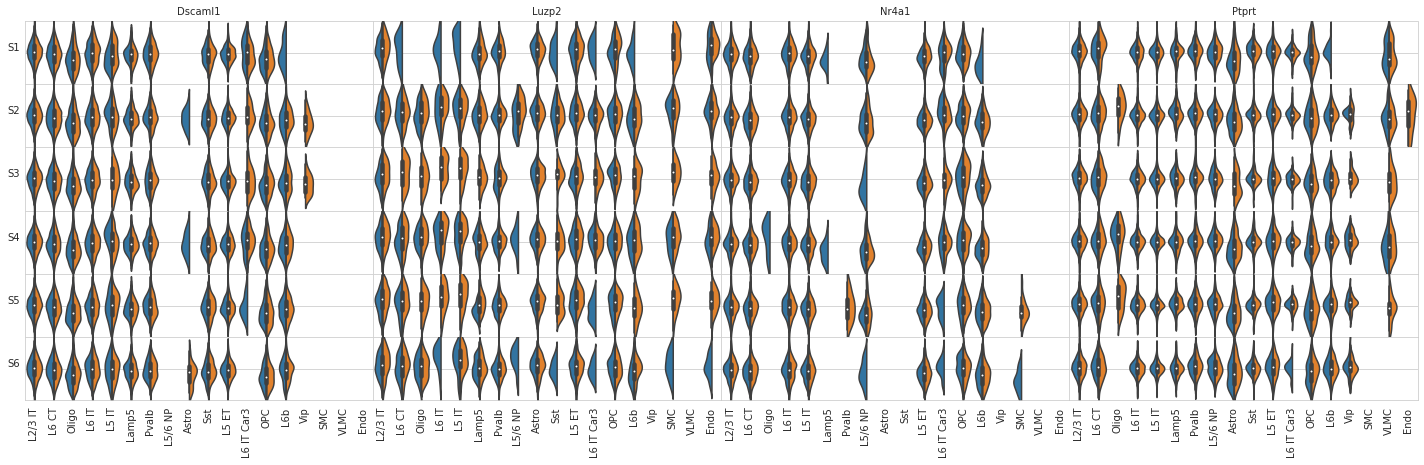

In [41]:
#Trying to plot multiple genes on the same plot
sns.set_style("whitegrid")

genes = ['Ptprt','Dscaml1','Luzp2','Nr4a1']
cat_df = gc_mop[gc_mop['gene'].isin(genes)].copy()
cat_df['mouse'] = 'Mouse '+cat_df['sample_id'].str[1]
cat_df['sample'] = 'S'+cat_df['sample_id'].str[3]
cat_df.head()

uniq_genes = sorted(cat_df['gene'].unique())
uniq_samples = sorted(cat_df['sample'].unique())

g = sns.catplot(
    x = 'ontology',
    y = 'score',
    hue = 'mouse',
    split = True,
    kind = 'violin',
    row = 'sample',
    col = 'gene',
    row_order = uniq_samples,
    col_order = uniq_genes,
    legend = False,
    height = 1,
    aspect = 5,
    data = cat_df,
)

#Formatting presentation
(
    g.set_titles('{col_name}')
     .set_xticklabels(rotation=90)
     .set_yticklabels(rotation=0)
     .despine(right=False)
     .set(
         ylim=(-1,1),
         yticks=[-1,0,1],
         yticklabels=[],
         xlabel='',
     )
     
)

#Have to manually change the plot titles (???) ridiculous
for i,row_ax in enumerate(g.axes):
    for j,sp_ax in enumerate(row_ax):
        if j == 0:
            sp_ax.set_ylabel(uniq_samples[i],rotation=0)
        if i > 0:
            sp_ax.set_title('')
                        

plt.subplots_adjust(wspace=0,hspace=0)
plt.show()
plt.close()

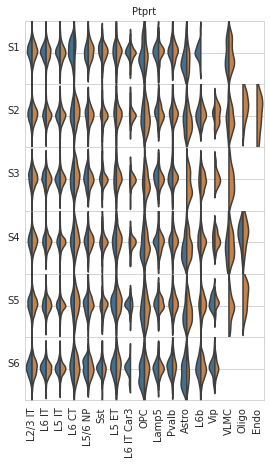

In [42]:
#Plot one gene at a time
sns.set_style("whitegrid")

gene = 'Ptprt'


sig_samp_onts = (
    mop_df[
        mop_df['gene'].eq(gene)
    ].set_index(
        ['sample_id','ontology']
    )['bh_p'].le(0.05)
)

cat_df = gc_mop[gc_mop['gene'].eq(gene)].copy()
cat_df = cat_df.set_index(['sample_id','ontology'])
cat_df['Significant'] = sig_samp_onts
cat_df = cat_df.reset_index()

cat_df['mouse'] = 'Mouse '+cat_df['sample_id'].str[1]
cat_df['sample'] = 'S'+cat_df['sample_id'].str[3]

uniq_genes = sorted(cat_df['gene'].unique())
uniq_samples = sorted(cat_df['sample'].unique())
uniq_mice = sorted(cat_df['mouse'].unique())
uniq_onts = sorted(cat_df['ontology'].unique())

g = sns.catplot(
    x = 'ontology',
    y = 'score',
    hue = 'mouse',
    split = True,
    kind = 'violin',
    inner = None,
    row = 'sample',
    col = 'gene',
    scale = 'count', #scale width of violins by number of cells
    scale_hue = True,
    saturation = 0.5,
    row_order = uniq_samples,
    col_order = uniq_genes,
    legend = False,
    height = 1,
    aspect = 4,
    data = cat_df,
)

#Formatting presentation
(
    g.set_titles('{col_name}')
     .set_xticklabels(rotation=90)
     .despine(right=False)
     .set(
         ylim=(-1,1),
         yticks=[-1,0,1],
         yticklabels=[],
         xlabel='',
     )
     
)

#Have to manually change the plot titles (???) ridiculous
for i,row_ax in enumerate(g.axes):
    for j,sp_ax in enumerate(row_ax):
        if j == 0:
            sp_ax.set_ylabel(uniq_samples[i],rotation=0)
        if i > 0:
            sp_ax.set_title('')
            
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()
plt.close()

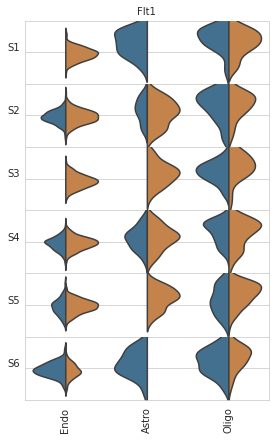

In [45]:
#Plot one gene at a time but only significant celltypes
sns.set_style("whitegrid")

gene = 'Flt1'


sig_samp_onts = (
    mop_df[
        mop_df['gene'].eq(gene)
    ].set_index(
        ['sample_id','ontology']
    )['bh_p'].le(0.05)
)

cat_df = gc_mop[gc_mop['gene'].eq(gene)].copy()
cat_df = cat_df.set_index(['sample_id','ontology'])
cat_df['Significant'] = sig_samp_onts
cat_df = cat_df.reset_index()

cat_df = cat_df[cat_df['Significant']] #NOTE FILTERING TO JUST THE SIGNIFICANT sample/celltypes
cat_df = cat_df[cat_df['ontology'].isin(['Endo','Astro','Oligo'])] #Note subsetting even more

cat_df['mouse'] = 'Mouse '+cat_df['sample_id'].str[1]
cat_df['sample'] = 'S'+cat_df['sample_id'].str[3]

uniq_genes = sorted(cat_df['gene'].unique())
uniq_samples = sorted(cat_df['sample'].unique())
uniq_mice = sorted(cat_df['mouse'].unique())
uniq_onts = sorted(cat_df['ontology'].unique())

g = sns.catplot(
    x = 'ontology',
    y = 'score',
    hue = 'mouse',
    split = True,
    kind = 'violin',
    inner = None,
    row = 'sample',
    col = 'gene',
    scale = 'count', #scale width of violins by number of cells
    scale_hue = True,
    saturation = 0.5,
    row_order = uniq_samples,
    col_order = uniq_genes,
    legend = False,
    height = 1,
    aspect = 4,
    data = cat_df,
)

#Formatting presentation
(
    g.set_titles('{col_name}')
     .set_xticklabels(rotation=90)
     .despine(right=False)
     .set(
         ylim=(-1,1),
         yticks=[-1,0,1],
         yticklabels=[],
         xlabel='',
     )
     
)

#Have to manually change the plot titles (???) ridiculous
for i,row_ax in enumerate(g.axes):
    for j,sp_ax in enumerate(row_ax):
        if j == 0:
            sp_ax.set_ylabel(uniq_samples[i],rotation=0)
        if i > 0:
            sp_ax.set_title('')
            
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()
plt.close()

In [11]:
g.set_ylabels?

In [12]:
g.set_axis_labels?

# MOp merfish gene/ontology results on all 95 MERFISH ontologies


Don't think I want to use this, instead use the 10X-ontologies above

In [13]:
mop_df = pd.read_csv('../outputs/gene_ontology/Merfish_MOp_peripheral.csv')
mop_df.head()

,sample_id,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,m1s1,Acta2,L23_IT_1,274,6.0,618.0,0.110623,25.760223,32.624380,4.510020,6.482149e-06,0.000043
1,m1s1,Acta2,L23_IT_3,50,6.0,649.5,0.036826,2.385558,6.037982,0.970832,3.316320e-01,0.480232
2,m1s1,Acta2,L23_IT_4,73,6.0,563.0,0.051282,-1.153523,8.295889,-0.400493,6.887936e-01,0.793137
3,m1s1,Acta2,L45_IT_1,59,6.0,478.0,0.155263,6.774675,7.123242,2.538339,1.113800e-02,0.032652
4,m1s1,Acta2,L45_IT_3,146,6.0,626.5,0.194169,20.359247,17.245112,4.902625,9.456429e-07,0.000007


In [14]:
mop_df['annotation'].nunique()

95

In [15]:
#more than half of the gene/ontologies are significant from MOp
mop_df['bh_p'].le(0.05).value_counts()

False    22898
True     13413
Name: bh_p, dtype: int64

In [16]:
#97 genes have significant peripheral in at least one celltype,
#and significant central in at least one other celltype
pos_and_neg_sig = (
    mop_df[
        mop_df['bh_p'].le(0.05)
    ].groupby('gene').filter(
        lambda g: g['med_score'].gt(0).nunique() > 1
    )
)

pos_and_neg_sig['gene'].nunique()

97

# SeqFish+ gene/ontology results

In [17]:
seq_df = pd.read_csv('../outputs/gene_ontology/SeqFish_peripheral.csv')
seq_df.head()

,sample_id,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,m1s1,Aamp,Excitatory layer 5/6,20,5.5,12498.0,0.094839,2.226461,2.419260,1.431442,0.152304,0.358706
1,m1s1,Abhd12,Excitatory layer 3,27,7.0,6857.0,0.077749,2.312100,3.110525,1.310961,0.189871,0.400258
2,m1s1,Abhd12,Excitatory layer 5/6,37,9.0,9883.0,0.078507,2.429686,3.503960,1.297988,0.194292,0.402065
3,m1s1,Abhd2,choroid plexus,65,8.0,2346.0,-0.047155,-3.246480,6.201979,-1.303610,0.192367,0.401358
4,m1s1,Abhd8,Excitatory layer 3,50,8.0,6110.5,0.003112,2.237509,4.840814,1.016964,0.309171,0.536310


In [18]:
seq_df['gene'].nunique()

284

In [19]:
seq_df['annotation'].nunique()

11

In [20]:
seq_df['bh_p'].le(0.05).value_counts()

False    402
True     105
Name: bh_p, dtype: int64

In [21]:
'Flt1' in seq_df['gene'].values

False

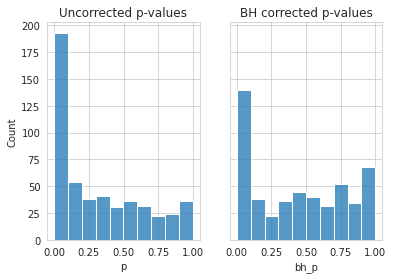

In [22]:
fig,axs = plt.subplots(ncols=2,nrows=1,sharey=True)
sns.histplot(seq_df['p'],ax=axs[0])
sns.histplot(seq_df['bh_p'],ax=axs[1])
axs[0].set_title('Uncorrected p-values')
axs[1].set_title('BH corrected p-values')
plt.show()
plt.close()

In [23]:
#no genes have significant peripheral in one celltype, and significant central in another celltype
pos_and_neg_sig = (
    seq_df[
        seq_df['bh_p'].le(0.05)
    ].groupby('gene').filter(
        lambda g: g['med_score'].gt(0).nunique() > 1
    )
)

pos_and_neg_sig

,sample_id,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p


In [24]:
#Kif5a has the highest number of significant ontologies at 5
seq_df[seq_df['bh_p'].le(0.05)]['gene'].value_counts()

Kif5a     5
Sptbn2    4
Lingo1    3
Agap2     3
Cplx1     3
         ..
Rnf157    1
Igsf9b    1
Ncs1      1
Wbp2      1
Eng       1
Name: gene, Length: 76, dtype: int64

In [25]:
#reading in the gene-cell SRRS results for plotting
seq_gc_df = pd.read_csv('../outputs/gene_cell/SeqFish_peripheral.csv')
seq_gc_df.head()

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance,mouse,sample,replicate
0,peripheral,cell_115,Endothelial,843,Aanat,1,821.0,-0.947743,0.334125,1,1,1
1,peripheral,cell_115,Endothelial,843,Aar2,1,369.0,0.125891,0.334125,1,1,1
2,peripheral,cell_115,Endothelial,843,Aars,1,470.0,-0.114014,0.334125,1,1,1
3,peripheral,cell_115,Endothelial,843,Aatf,1,487.0,-0.154394,0.334125,1,1,1
4,peripheral,cell_115,Endothelial,843,Ackr3,2,443.0,-0.049881,0.166864,1,1,1


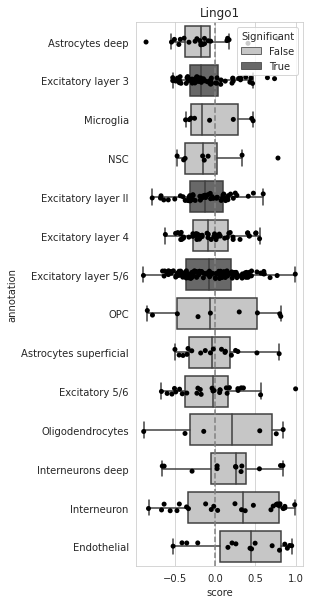

In [26]:
gene = 'Lingo1'


plot_df = seq_gc_df[
    seq_gc_df['gene'].eq(gene) &
    seq_gc_df['annotation'].ne('unannotated')
]

ann_to_bh_p = dict(seq_df[seq_df['gene'].eq(gene)][['annotation','bh_p']].values)
plot_df['bh_p'] = plot_df['annotation'].map(ann_to_bh_p)
plot_df['Significant'] = plot_df['bh_p'].le(0.05)

plot_df['median_score'] = plot_df.groupby('annotation')['score'].transform('median')
plot_df = plot_df.sort_values('median_score')
plot_df = plot_df.groupby('annotation').filter(lambda g: len(g) > 5)

fig = plt.figure(figsize=(3,10))
sns.boxplot(
    x = 'score',
    y = 'annotation',
    hue = 'Significant',
    palette = 'Greys',
    dodge = False,
    fliersize = 0,
    data = plot_df,
)
sns.stripplot(
    x = 'score',
    y = 'annotation',
    color = 'black',
    data = plot_df,
)
plt.axvline(0,color='grey',linestyle='dashed')
plt.title(gene)
plt.show()
plt.close()